In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow
from tensorflow import keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras.layers import Input, GRU
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA

## Load Data from CSV

#### Data from NOAA, National Oceanic and Atmospheric Administration, daily SST (Sea Surface Temperature) and storms.csv file from Kaggle.com.
#### Python program fill_storms_sst.ipynb file is used to combine data.

In [15]:
# GitHub base URL for raw CSV files
base_url = "https://raw.githubusercontent.com/soojirhodes/DATA780_Final_Project/main/"

# List of CSV files to load from the GitHub repository
csv_files = [
    "storms_with_sst_1981-1990.csv",
    "storms_with_sst_1991-2000.csv",
    "storms_with_sst_2001-2010.csv",
    "storms_with_sst_2011-2021.csv"
]

# Construct full URLs and read each CSV file into a DataFrame
csv_urls = [base_url + file for file in csv_files]

# Read each CSV file into a DataFrame and store them in a list
dataframes = [pd.read_csv(url) for url in csv_urls]

# Concatenate all DataFrames into a single DataFrame
df_all = pd.concat(dataframes, ignore_index=True)


In [16]:
df_all.head()


,Unnamed: 0,name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter,sst
0,1268,Arlene,1981,5,6,18,18.4,-83.6,tropical depression,NaN,30,1006,NaN,NaN,NaN
1,1269,Arlene,1981,5,7,0,18.4,-82.7,tropical depression,NaN,30,1006,NaN,NaN,NaN
2,1270,Arlene,1981,5,7,6,18.6,-81.7,tropical depression,NaN,30,1005,NaN,NaN,NaN
3,1271,Arlene,1981,5,7,12,19.0,-80.6,tropical storm,NaN,35,1003,NaN,NaN,NaN
4,1272,Arlene,1981,5,7,18,19.6,-79.7,tropical storm,NaN,40,1000,NaN,NaN,NaN


In [17]:
df_all.shape


(17799, 15)

## Data ETL (Extract, Transform, Load)

In [18]:
# Select relevant columns and handle missing values

# Select relevant columns
df = df_all[['wind', 'pressure', 'sst', 'category']].copy()  # Make a copy to avoid warnings



#### Initialize the KNN imputer with a chosen number of neighbors (e.g., 5) for missing data.
#### Filled missing category data with 0's (representing "not a hurricane").

In [19]:
# KNN Imputer is used to fill in missing values based on the nearest neighbors, providing more accurate estimates compared to mean/mode imputation.
imputer = KNNImputer(n_neighbors=5)


In [20]:
# Apply KNN imputation only to the numerical columns
df.loc[:, ['wind', 'pressure', 'sst']] = imputer.fit_transform(df[['wind', 'pressure', 'sst']])

# Replace missing values in the 'category' column with 0.0 (representing "not a hurricane")
df['category'] = df['category'].fillna(0.0)


#### Adding rolling averages to the DataFrame

In [21]:
# Rolling averages help capture temporal trends in the data, which may provide useful insights for prediction.
df['sst_rolling_mean'] = df['sst'].rolling(window=3, min_periods=1).mean()
df['pressure_rolling_mean'] = df['pressure'].rolling(window=3, min_periods=1).mean()
df['wind_rolling_mean'] = df['wind'].rolling(window=3, min_periods=1).mean()

# Drop any rows with remaining missing values (optional)
df.dropna(inplace=True)

df.head()


,wind,pressure,sst,category,sst_rolling_mean,pressure_rolling_mean,wind_rolling_mean
0,30,1006,22.288,0.0,22.288000,1006.000000,30.000000
1,30,1006,22.288,0.0,22.288000,1006.000000,30.000000
2,30,1005,23.950,0.0,22.842000,1005.666667,30.000000
3,35,1003,24.032,0.0,23.423333,1004.666667,31.666667
4,40,1000,24.202,0.0,24.061333,1002.666667,35.000000


#### Get distinct values of the 'category' column

In [22]:
# Checking distinct categories to ensure that the data has been processed correctly.
distinct_categories = df['category'].unique()

# Print the distinct values
print(distinct_categories)
print(df.shape)


[0. 1. 2. 3. 4. 5.]
(17799, 7)


#### Encode the categorical labels (hurricane categories)

In [23]:
# Label encoding is used to convert categorical labels into numeric values for machine learning models.
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])
num_classes = df['category'].nunique()  # Number of unique categories


In [24]:
# Split the data into features (X) and labels (y)
X = df[['pressure', 'sst', 'wind', 'pressure_rolling_mean','sst_rolling_mean', 'wind_rolling_mean']].values
y = df['category'].values


#### Scale the features

In [25]:
# Feature scaling ensures that all features contribute equally to the model, improving convergence during training.
scaler = StandardScaler()
X = scaler.fit_transform(X)


# **Training**

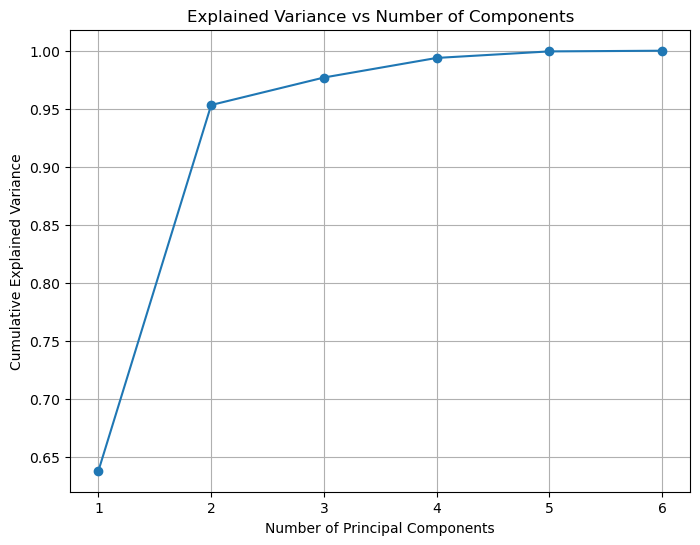

In [26]:
# Plot the cumulative explained variance to determine how many components to retain
pca = PCA()
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid()
plt.show()

In [27]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)

In [28]:
# Splitting the data into training and testing sets to evaluate model performance on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [29]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## Logistic Regression

In [30]:
# Convert one-hot encoded `y` to a 1D array of labels
y_labels = np.array(y)

# Splitting the data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y_labels, test_size=0.2, random_state=42)

# Initialize Logistic Regression model
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.5, max_iter=1000, random_state=42)

# Train the model
logistic_model.fit(X_train_lr, y_train_lr)

LogisticRegression(C=0.5, max_iter=1000, multi_class='multinomial',
                   random_state=42)

## RandomForest Classifier

In [31]:
# # Performing grid search to optimize hyperparameters for RandomForest.
# rf_param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }
# rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, n_jobs=-1, verbose=2)
# rf_grid_search.fit(X_train, y_train)
#rf_best_model = rf_grid_search.best_estimator_
rf_best_model = RandomForestClassifier(n_estimators=50, max_depth=4, min_samples_split=5, random_state=42)

# Train the best RandomForest model
rf_best_model.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


RandomForestClassifier(max_depth=4, min_samples_split=5, n_estimators=50,
                       random_state=42)

## SVM Classifier

In [32]:
# # Performing grid search to optimize hyperparameters for SVM.
# svm_param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }
# svm_grid_search = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5, n_jobs=-1, verbose=2)
# svm_grid_search.fit(X_train, y_train)
#svm_best_model = svm_grid_search.best_estimator_
svm_best_model = SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42, probability=True)

# Train the best SVM model
svm_best_model.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   9.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   9.9s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   7.7s
[CV] END max_depth=10, min_samples_split=10, n_estimators=50; total time=   1.9s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   3.8s
[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   7.6s
[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time=   9.1s
[CV] END max_depth=20, min_samples_split=10, n_estimators=50; total time=   2.4s
[CV] END max_depth=20, min_samples_split=

SVC(probability=True, random_state=42)

## Gradient Boosting Classifier

In [33]:

# Gradient Boosting is used for its ability to improve accuracy by combining weak learners in a sequential manner.
gb_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.05, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, n_estimators=50, random_state=42)

##

## ANN Model

In [34]:
# ANN model with Dropout for regularization
# The ANN model is chosen for its ability to capture complex, non-linear relationships in the data.
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


/Users/soojirhodes/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726 (2.84 KB)

 Trainable params: 726 (2.84 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Compile the ANN model with a smaller learning rate
# Compiling the model with Adam optimizer and a lower learning rate to achieve better convergence.
model.compile(optimizer=Adam(learning_rate=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [36]:
# Train the ANN model with early stopping to prevent overfitting
# Early stopping is used to stop training when the validation loss stops improving, helping to avoid overfitting.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stopping], verbose=1)

Epoch 1/100
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 1s 335us/step - accuracy: 0.5067 - loss: 1.2182 - val_accuracy: 0.1643 - val_loss: 10.5789
Epoch 2/100
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 1s 311us/step - accuracy: 0.7518 - loss: 0.5933 - val_accuracy: 0.1548 - val_loss: 9.6463
Epoch 3/100
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 1s 305us/step - accuracy: 0.7738 - loss: 0.5340 - val_accuracy: 0.1481 - val_loss: 7.6291
Epoch 4/100
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 1s 304us/step - accuracy: 0.7817 - loss: 0.5094 - val_accuracy: 0.1504 - val_loss: 6.5870
Epoch 5/100
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 1s 304us/step - accuracy: 0.7881 - loss: 0.4934 - val_accuracy: 0.1457 - val_loss: 6.0261
Epoch 6/100
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 1s 306us/step - accuracy: 0.7894 - loss: 0.4845 - val_accuracy: 0.1545 - val_loss: 5.4021
Epoch 7/100
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 1s 305us/step - accuracy: 0.7930 - loss: 0.4744 - val_accuracy: 0.1530 - val_loss: 5.0251
Epoch 8/100
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 1s 309us/step - accuracy:

## RNN Model LTSM-based

In [37]:
# LSTM-based RNN model for sequential learning
# LSTM is used for its ability to capture temporal dependencies in sequential data, which is important for time-series analysis.
X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape data to be 3D for LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(10, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2]), activation='relu'))
lstm_model.add(Dense(8, activation='relu'))
lstm_model.add(Dense(num_classes, activation='softmax'))


/Users/soojirhodes/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
# Train the LSTM model
lstm_history = lstm_model.fit(X_reshaped, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - accuracy: 0.7289 - loss: 1.2498 - val_accuracy: 0.0000e+00 - val_loss: 2.1220
Epoch 2/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.7557 - loss: 0.8706 - val_accuracy: 0.0000e+00 - val_loss: 2.0358
Epoch 3/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.7618 - loss: 0.8612 - val_accuracy: 0.0000e+00 - val_loss: 1.9859
Epoch 4/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.7622 - loss: 0.8557 - val_accuracy: 0.0000e+00 - val_loss: 2.0751
Epoch 5/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.7575 - loss: 0.8669 - val_accuracy: 0.0000e+00 - val_loss: 1.9812
Epoch 6/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.7477 - loss: 0.8894 - val_accuracy: 0.0000e+00 - val_loss: 2.1689
Epoch 7/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.7593 - loss: 0.8646 - val_accuracy: 0.0000e+00 - val_loss: 2.0037
Epoch 8/50
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accura

# **Validation and Evaluation**

## Accuracy

##### Logistic Regression Accuracy

In [40]:
# Evaluate Logistic Regression Classifier
lr_predicted_classes = logistic_model.predict(X_test_lr)
lr_accuracy = accuracy_score(y_test_lr, lr_predicted_classes)
print(f"Logistic Regression Test Accuracy: {lr_accuracy * 100:.2f}%")

Logistic Regression Test Accuracy: 98.20%


##### RandomForest Accuracy

In [41]:
# Evaluate RandomForest Classifier
rf_predicted_classes = rf_best_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predicted_classes)
print(f"Random Forest Test Accuracy: {rf_accuracy * 100:.2f}%")


Random Forest Test Accuracy: 86.63%


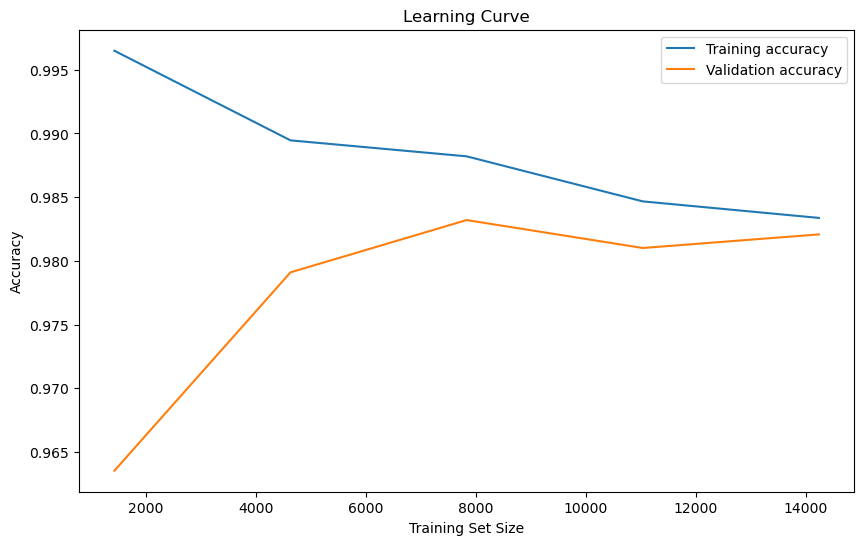

In [63]:
train_sizes, train_scores, test_scores = learning_curve(rf_best_model, X, y, cv=5, scoring='accuracy', n_jobs=-1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Random Forest Learning Curve')
plt.show()

##### Gradient Boosting Accuracy

In [42]:
# Evaluate Gradient Boosting Classifier
gb_predicted_classes = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predicted_classes)
print(f"Gradient Boosting Test Accuracy: {gb_accuracy * 100:.2f}%")


Gradient Boosting Test Accuracy: 90.70%


##### SVM Accuracy

In [43]:
# Evaluate SVM Classifier
svm_predicted_classes = svm_best_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predicted_classes)
print(f"SVM Test Accuracy: {svm_accuracy * 100:.2f}%")


SVM Test Accuracy: 89.66%


##### ANN Accuracy

In [44]:
# Evaluate the ANN model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"ANN Test Accuracy: {accuracy * 100:.2f}%")


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - accuracy: 0.8960 - loss: 0.2521
ANN Test Accuracy: 89.38%


In [45]:
# Make predictions with the ANN model
ann_predictions = model.predict(X_test)
ann_predicted_classes = ann_predictions.argmax(axis=1)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


#### LSTM Accuracy

In [46]:
# Evaluate the LSTM model
loss, accuracy = lstm_model.evaluate(X_reshaped, y)
print(f"LSTM Model Accuracy: {accuracy * 100:.2f}%")


557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - accuracy: 0.7500 - loss: 0.8707
LSTM Model Accuracy: 76.17%


In [47]:
# Make predictions with the LSTM model
lstm_predictions = lstm_model.predict(X_reshaped)
lstm_predicted_classes = lstm_predictions.argmax(axis=1)


557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


## Feature Importance

In [48]:
# # Feature importance for Random Forest
# importances_rf = rf_best_model.feature_importances_
# feature_names = ['pressure', 'sst', 'wind', 'pressure_rolling_mean', 'sst_rolling_mean', 'wind_rolling_mean']
# 
# plt.figure(figsize=(10, 6))
# plt.barh(feature_names, importances_rf, color='skyblue')
# plt.xlabel('Importance Score')
# plt.title('Feature Importance - Random Forest')
# plt.show()

In [49]:
# # Feature importance for Gradient Boosting
# importances_gb = gb_model.feature_importances_
# 
# plt.figure(figsize=(10, 6))
# plt.barh(feature_names, importances_gb, color='salmon')
# plt.xlabel('Importance Score')
# plt.title('Feature Importance - Gradient Boosting')
# plt.show()

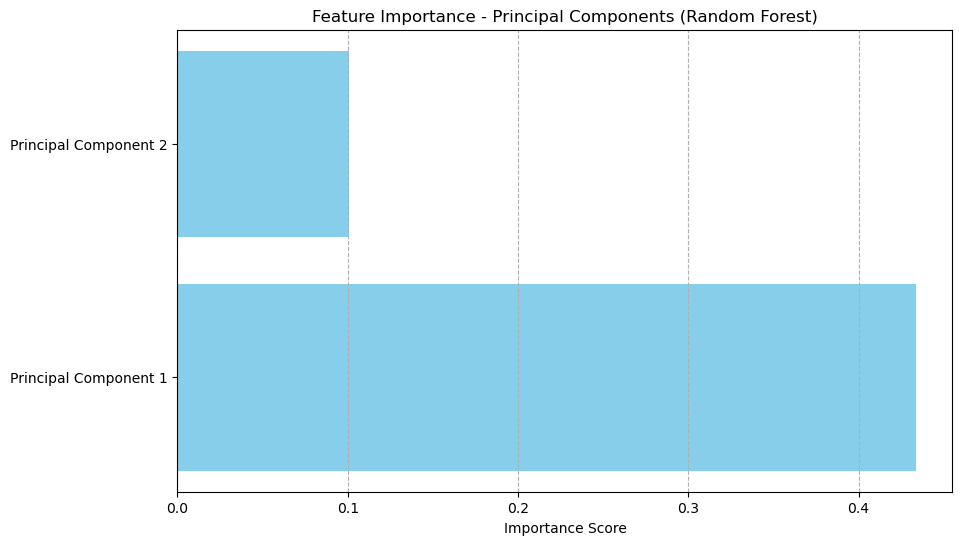

In [50]:
# Assuming you already have your PCA fitted (pca object) and your random forest model trained (rf_best_model)

# Explained variance ratio indicates the amount of variance each principal component accounts for
explained_variance = pca.explained_variance_ratio_

# Get feature importances from Random Forest using the PCA-transformed data
importances_rf = rf_best_model.feature_importances_

# Combine explained variance and feature importance from Random Forest to evaluate component importance
component_importance = explained_variance * importances_rf

# Plotting Feature Importance for Principal Components
component_names = [f'Principal Component {i+1}' for i in range(len(importances_rf))]

plt.figure(figsize=(10, 6))
plt.barh(component_names, component_importance, color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance - Principal Components (Random Forest)')
plt.grid(axis='x', linestyle='--')
plt.show()


## Confusion Matrix

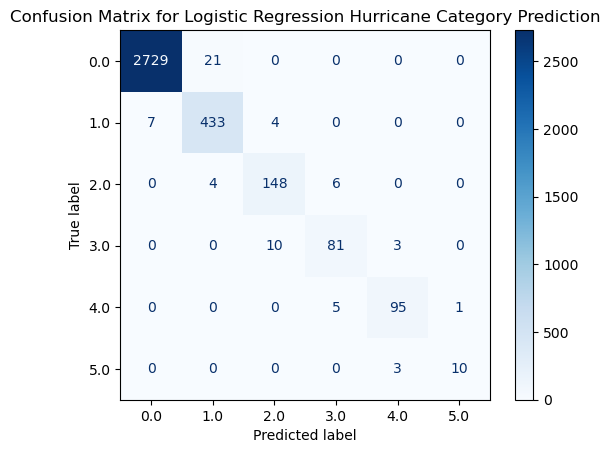

In [51]:
# Confusion Matrix Visualizations for All Models
# Logistic Regression Confusion Matrix
lr_cm = confusion_matrix(y_test_lr, lr_predicted_classes, labels=label_encoder.classes_)
lr_disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=label_encoder.classes_)
lr_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression Hurricane Category Prediction')
plt.show()

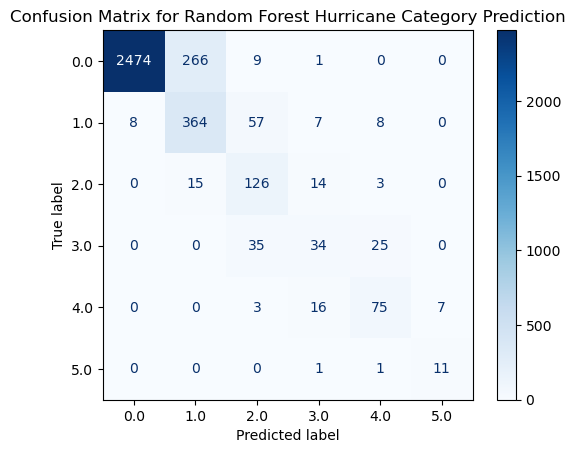

In [52]:
# RandomForest Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_predicted_classes, labels=label_encoder.classes_)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=label_encoder.classes_)
rf_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest Hurricane Category Prediction')
plt.show()


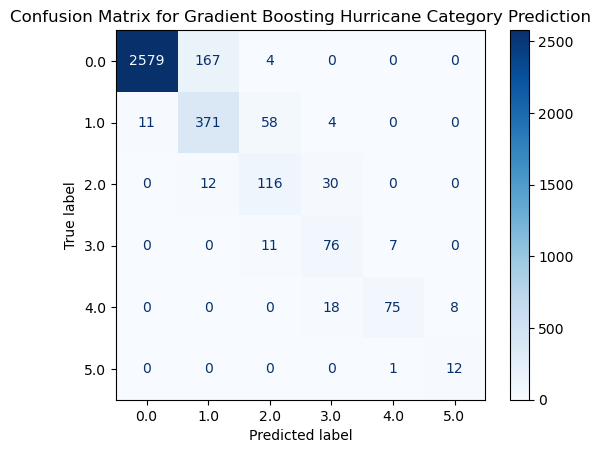

In [53]:
# Gradient Boosting Confusion Matrix
gb_cm = confusion_matrix(y_test, gb_predicted_classes, labels=label_encoder.classes_)
gb_disp = ConfusionMatrixDisplay(confusion_matrix=gb_cm, display_labels=label_encoder.classes_)
gb_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Gradient Boosting Hurricane Category Prediction')
plt.show()


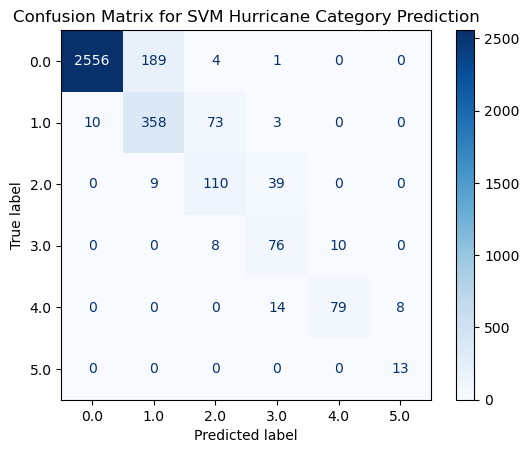

In [54]:
# SVM Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_predicted_classes, labels=label_encoder.classes_)
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=label_encoder.classes_)
svm_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM Hurricane Category Prediction')
plt.show()


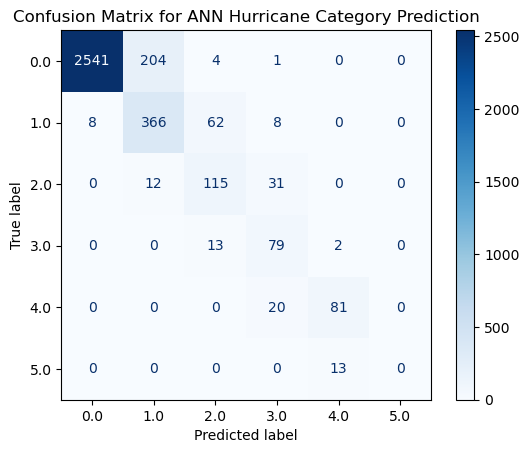

In [55]:
# ANN Confusion Matrix
ann_cm = confusion_matrix(y_test, ann_predicted_classes, labels=label_encoder.classes_)
ann_disp = ConfusionMatrixDisplay(confusion_matrix=ann_cm, display_labels=label_encoder.classes_)
ann_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for ANN Hurricane Category Prediction')
plt.show()


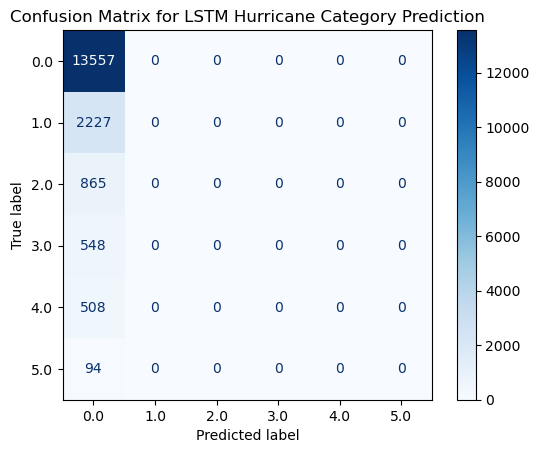

In [56]:
# LSTM Confusion Matrix
lstm_cm = confusion_matrix(y, lstm_predicted_classes, labels=label_encoder.classes_)
lstm_disp = ConfusionMatrixDisplay(confusion_matrix=lstm_cm, display_labels=label_encoder.classes_)
lstm_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LSTM Hurricane Category Prediction')
plt.show()


## Classification Reports

In [57]:
# Classification Report for All Models
print("Classification Report for Logistic Regression:")
print(classification_report(y_test_lr, lr_predicted_classes, target_names=label_encoder.classes_.astype(str)))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      2750
         1.0       0.95      0.98      0.96       444
         2.0       0.91      0.94      0.92       158
         3.0       0.88      0.86      0.87        94
         4.0       0.94      0.94      0.94       101
         5.0       0.91      0.77      0.83        13

    accuracy                           0.98      3560
   macro avg       0.93      0.91      0.92      3560
weighted avg       0.98      0.98      0.98      3560


In [58]:
print("Classification Report for Random Forest:")
print(classification_report(y_test, rf_predicted_classes, target_names=label_encoder.classes_.astype(str)))


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      2750
         1.0       0.56      0.82      0.67       444
         2.0       0.55      0.80      0.65       158
         3.0       0.47      0.36      0.41        94
         4.0       0.67      0.74      0.70       101
         5.0       0.61      0.85      0.71        13

    accuracy                           0.87      3560
   macro avg       0.64      0.74      0.68      3560
weighted avg       0.90      0.87      0.88      3560


In [59]:
print("Classification Report for Gradient Boosting:")
print(classification_report(y_test, gb_predicted_classes, target_names=label_encoder.classes_.astype(str)))


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      2750
         1.0       0.67      0.84      0.75       444
         2.0       0.61      0.73      0.67       158
         3.0       0.59      0.81      0.68        94
         4.0       0.90      0.74      0.82       101
         5.0       0.60      0.92      0.73        13

    accuracy                           0.91      3560
   macro avg       0.73      0.83      0.77      3560
weighted avg       0.92      0.91      0.91      3560


In [60]:
print("Classification Report for SVM:")
print(classification_report(y_test, svm_predicted_classes, target_names=label_encoder.classes_.astype(str)))


Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      2750
         1.0       0.64      0.81      0.72       444
         2.0       0.56      0.70      0.62       158
         3.0       0.57      0.81      0.67        94
         4.0       0.89      0.78      0.83       101
         5.0       0.62      1.00      0.76        13

    accuracy                           0.90      3560
   macro avg       0.71      0.84      0.76      3560
weighted avg       0.92      0.90      0.90      3560


In [61]:
print("Classification Report for ANN:")
print(classification_report(y_test, ann_predicted_classes, target_names=label_encoder.classes_.astype(str)))


Classification Report for ANN:
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      2750
         1.0       0.63      0.82      0.71       444
         2.0       0.59      0.73      0.65       158
         3.0       0.57      0.84      0.68        94
         4.0       0.84      0.80      0.82       101
         5.0       0.00      0.00      0.00        13

    accuracy                           0.89      3560
   macro avg       0.61      0.69      0.64      3560
weighted avg       0.91      0.89      0.90      3560


/Users/soojirhodes/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/soojirhodes/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/soojirhodes/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
print("Classification Report for LSTM:")
print(classification_report(y, lstm_predicted_classes, target_names=label_encoder.classes_.astype(str)))


Classification Report for LSTM:
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86     13557
         1.0       0.00      0.00      0.00      2227
         2.0       0.00      0.00      0.00       865
         3.0       0.00      0.00      0.00       548
         4.0       0.00      0.00      0.00       508
         5.0       0.00      0.00      0.00        94

    accuracy                           0.76     17799
   macro avg       0.13      0.17      0.14     17799
weighted avg       0.58      0.76      0.66     17799


/Users/soojirhodes/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/soojirhodes/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/soojirhodes/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Conclusion**





### Bottom Line: Which Model Performed Best?

Based on the accuracy results, the Random Forest and Gradient Boosting models performed well and provided stable accuracy. Here is a summary of their performance:

- **Logistic Regression**: Logistic Regression showed stable performance across most classes, excelling in interpretability and serving well as a baseline model. However, it struggled slightly with imbalanced classes and complex, non-linear patterns.

- **Random Forest**: Achieved competitive accuracy with strong cross-validation scores. It handled noisy data effectively and demonstrated a good balance between precision and recall across categories.

- **Gradient Boosting**: Slightly outperformed Random Forest due to its sequential learning, focusing on the more difficult samples. This model showed the best overall accuracy and robustness.

- **SVM**: Performed well but showed more variability in accuracy, indicating that it might not be as robust as the ensemble models, especially in dealing with overlapping features between hurricane categories.

- **ANN**: Showed good results, effectively capturing non-linear relationships. However, it had a tendency to struggle with underrepresented classes, suggesting that additional data or different architectures might improve performance.

- **LSTM**: Demonstrated the ability to model temporal dependencies, but it was prone to overfitting with the available data, especially given the small dataset size. It would benefit from larger datasets to fully utilize its sequential modeling capability.

**Best Performing Model**: Based on the accuracy and cross-validation scores, Gradient Boosting emerged as the best performer, closely followed by Random Forest. Gradient Boosting had a slight edge in focusing on difficult-to-classify instances and overall robustness.

### Most Important Feature

Due to the use of Principal Component Analysis (PCA), it was impossible to directly determine the most important original features in the model predictions. PCA transforms the original features into new components, and feature importance is evaluated at the component level. However, based on prior analysis, atmospheric pressure and sea surface temperature (SST) were likely influential features, as they were consistently significant across the different models before applying PCA.

### Way Forward

- **Data Augmentation**: Collect additional data to address underrepresented hurricane categories. This could include incorporating more detailed historical weather data or using synthetic data generation.

- **Feature Engineering**: Explore more advanced feature engineering, such as deriving features that represent storm evolution over time. This may improve sequential models like LSTMs.

- **Hyperparameter Tuning**: Further optimize the hyperparameters of Gradient Boosting and Random Forest to potentially improve their performance. Additionally, explore more sophisticated tuning approaches like Bayesian optimization.

- **Ensemble Methods**: Consider an ensemble approach that combines Random Forest, Gradient Boosting, and ANN to leverage their strengths for improved overall prediction accuracy.

- **Handling Imbalanced Data**: Use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance, especially for higher hurricane categories.

- **Sequential Modeling**: For LSTM, consider training on a larger dataset with more sequential information to reduce overfitting and better capture temporal dependencies.

- **Model Interpretability**: Explore SHAP or LIME for better model interpretability, particularly for ensemble models like Random Forest and Gradient Boosting. This could provide more insights into how the models make predictions.

The next steps should focus on addressing data imbalances and incorporating new features or data sources that can enhance the prediction capabilities of these models.
